[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Hybrid YOLO + SAM 3 for Basketball Player Tracking and Heatmap Generation**

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

## Objective
This notebook demonstrates a cutting-edge workflow for building a basketball analytics tool using computer vision. We combine **YOLOv11** (for real-time object detection) with **Meta's SAM 3 (Segment Anything Model 3)** (for pixel-perfect segmentation). 

We leverage a custom-trained YOLO model to identify players, referees, and the ball, and then use SAM 3 to generate high-fidelity masks for precise visual tracking. The final output includes team-specific color overlays and activity heatmaps.

## Key Features
* **Hybrid Inference Pipeline**: Uses YOLOv11 to find bounding boxes and SAM 3 to generate "studio-quality" segmentation masks.
* **Team Classification**: Automatically distinguishes between Team A, Team B, Referees, and the Ball using custom-trained classes.
* **Zero-Shot Segmentation**: Leverages SAM 3's foundation model capabilities to handle complex occlusions and edge details (hair, shoes, jerseys) better than standard YOLO segmentation.
* **Smart Memory Management**: Implements dynamic resizing to run heavy SAM 3 models on standard GPUs without crashing.
* **Heatmap & Analytics**: Generates court coverage heatmaps to visualize player density and movement patterns.

## Libraries & Prerequisites
* **Core Libraries**: `ultralytics` (v8.3+), `opencv-python`, `numpy`, `torch`.
* **Models Required**:
    * `best (1).pt`: Custom fine-tuned YOLOv11 model for basketball.
    * `sam3.pt`: Meta's Segment Anything Model 3 weights (Manual download required).
* **Environment**: A GPU-enabled environment (Google Colab T4 or local NVIDIA GPU with 8GB+ VRAM) is strongly recommended.

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import matplotlib.pyplot as plt

# Check if GPU is available
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
model = YOLO('yolo11x-seg.pt') 
print("Model loaded successfully.")

CUDA Available: False
Model loaded successfully.


## Clone Repository
Clone the utility repository containing helper scripts for YOLO fine-tuning and data processing.

```bash
!git clone [https://github.com/Labellerr/yolo_finetune_utils.git](https://github.com/Labellerr/yolo_finetune_utils.git)

In [2]:
!git clone https://github.com/Labellerr/yolo_finetune_utils.git

Cloning into 'yolo_finetune_utils'...


## **Data Preparation: Frame Extraction**
To fine-tune the YOLO model, we first need to create a diverse dataset by extracting individual frames from our raw video footage. 

We use the `extract_random_frames` utility to randomly sample frames, which ensures we capture different angles, lighting conditions, and player positions without manually scrubbing through the video.

### **Parameters:**
* `paths`: List of video files to process (e.g., `['Recording 2026-01-16 142635.mp4']`).
* `total_images`: The number of frames to extract (set to **50** for this batch).
* `out_dir`: The folder where images will be saved (`dataset_frames`).
* `jpg_quality`: Image quality percentage (0-100). We use **100** to maintain maximum fidelity for labeling.
* `seed`: A random seed (e.g., **42**) ensures that if we run this cell again, we get the exact same set of frames.

In [3]:
from yolo_finetune_utils.frame_extractor import extract_random_frames

extract_random_frames(
    paths=['Recording 2026-01-16 142635.mp4'],
    total_images=50,
    out_dir="dataset_frames",
    jpg_quality=100,
    seed=42
)

[✓] Extracted 50 frames to folder: dataset_frames


##  Download Annotations from Labellerr

After completing data labeling on the **Labellerr** platform, export the annotations in **COCO JSON format**.

Download the COCO JSON file from the Labellerr website and upload it into this project workspace to use it for further dataset preparation and training.

This COCO JSON file will be used in the next steps for:
- Frame–annotation alignment
- COCO → YOLO format conversion
- Model training and evaluation


In [4]:
import os

os.rename(
    "export-#FyAH7CSExmVQ9qsa6esv.json",
    "New_Annotation.json"
)

# COCO to YOLO Format Conversion

Converts COCO-style segmentation annotations to YOLO segmentation dataset format.  
- Requires: `annotation.json` and images in `frames_output` directory.
- Output: Generated YOLO dataset folder.
- Parameters: allows train/val split, shuffling, and verbose mode.


In [5]:
from yolo_finetune_utils.coco_yolo_converter.seg_converter import coco_to_yolo_converter

coco_to_yolo_converter(
    json_path="New_Annotation.json",
    images_dir="dataset_frames",
    output_dir="yolo_dataset",
    use_split=True,
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1,
    shuffle=True,
    verbose=True
)

Conversion complete. Stats: {'train': 35, 'val': 10, 'test': 5}


{'stats': {'train': 35, 'val': 10, 'test': 5}, 'output_dir': 'yolo_dataset'}

## **Model Training: Fine-Tuning YOLOv11-Seg**

Now that our dataset is prepared and the environment is set up, we proceed to fine-tune the YOLO model. We are using **YOLOv11l-seg** (Large Segmentation model), which is pre-trained on the COCO dataset. By fine-tuning it on our specific basketball dataset, the model learns to detect and segment our custom classes (Players, Referees, Ball) with high accuracy.

### **Training Configuration:**
* **Model**: `yolo11l-seg.pt` (Large segmentation model for better accuracy).
* **Data**: Path to the `data.yaml` file, which defines the location of our training images and class names.
* **Epochs**: **50** (Number of complete passes through the dataset).
* **Image Size**: **640** (Input resolution for the model).
* **Batch Size**: **16** (Number of images processed at once; adjusted for GPU memory).
* **Device**: **0** (Uses the first available GPU, e.g., T4 on Colab).

In [ ]:

%pip install ultralytics
import ultralytics
ultralytics.checks()

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11l-seg.pt")

results = model.train(
    data="/content/drive/MyDrive/yolo_dataset (1)/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    device=0
)

## **Running Inference on Video**
We now apply our fine-tuned model (`best (1).pt`) to the target video to detect and track players. The script loads the video, processes it frame-by-frame using the YOLO model, and saves the annotated output as a new video file (`clean_output.mp4`).

A simple print statement is included to indicate that the inference process has started.

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO(r"best (1).pt") 

video_path = "Recording 2026-01-16 142635.mp4"
cap = cv2.VideoCapture(video_path)


w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))

out = cv2.VideoWriter("clean_output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))


results = model.predict(source=video_path, stream=True, imgsz=640, conf=0.5) 

print("Processing video... Press 'q' to stop early.")

for result in results:
    annotated_frame = result.plot(labels=True, conf=True, boxes=True)

    out.write(annotated_frame)

    cv2.imshow("YOLO Processing", annotated_frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()
print("Done! Saved as clean_output.mp4")

Processing video... Press 'q' to stop early.

video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 894.8ms
video 1/1 (frame 2/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 1 Refree, 1624.0ms
video 1/1 (frame 3/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 1 Refree, 1154.8ms
video 1/1 (frame 4/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 960.5ms
video 1/1 (frame 5/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 1030.6ms
video 1/1 (frame 6/1639) d:\Desktop\Desk\Labellerr Github Projects


video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 6 Team Bs, 5 Team As, 2 Refrees, 641.9ms


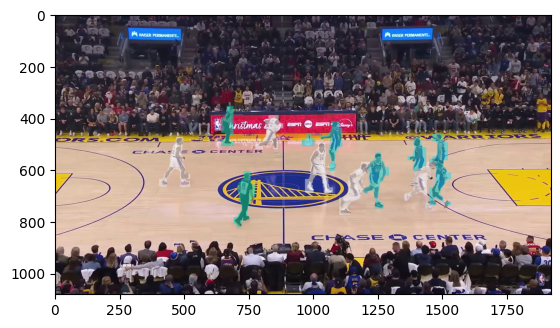

In [ ]:

results = model.predict(source="Recording 2026-01-16 142635.mp4", stream=True)
result = next(results)

clean_img = result.plot(boxes=False, masks=True, labels=False, conf=False)

import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB))
plt.show()


video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 754.6ms


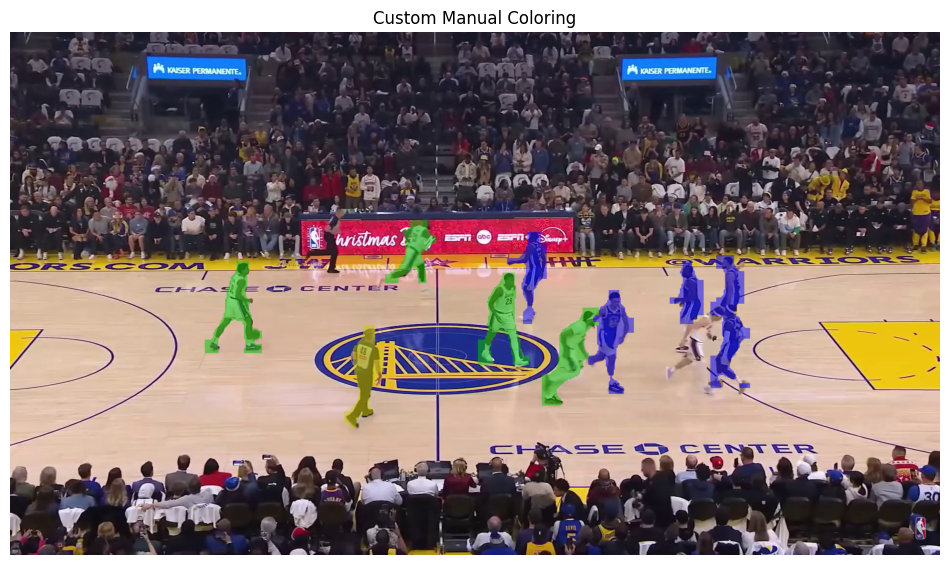

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("best (1).pt")

custom_palette = [
    (255, 255, 255),       # ID 0: Basket -> GREEN
    (255, 0, 0),       # ID 1: Team B -> BLUE
    (0, 200, 0),   # ID 2: Team A -> WHITE (Kept same)
    (0, 204, 204),     # ID 3: Refree -> DARK YELLOW (B=0, G=204, R=204)
    (0, 0, 255)
]

# 3. Run Inference on a Single Frame
video_path = "Recording 2026-01-16 142635.mp4"
results = model.predict(source=video_path, stream=True, conf=0.5)
result = next(results) # Get first frame

# 4. Manual Drawing Function
def draw_custom_masks(image, result, palette, alpha=0.5):
    """
    Manually draws filled masks with custom colors and transparency.
    """
    # Create a copy to draw the colored overlay
    overlay = image.copy()
    
    # Check if we have any detections
    if result.masks is not None:
        # Get list of masks (polygons) and class IDs
        masks_xy = result.masks.xy 
        class_ids = result.boxes.cls.cpu().numpy().astype(int)

        # Loop through every detection
        for mask, class_id in zip(masks_xy, class_ids):
            color = palette[class_id]
            
            # Convert polygon points to int32 (required by cv2)
            points = np.array(mask, dtype=np.int32)
            
            # Draw the filled polygon on the overlay layer
            cv2.fillPoly(overlay, [points], color)

    # Blend overlay with original image (Holograph effect)
    # alpha = transparency (0.5 means 50% see-through)
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# 5. Apply the function
original_img = result.orig_img  # The raw image from the video
final_img = draw_custom_masks(original_img, result, custom_palette, alpha=0.5)

# 6. Display
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Custom Manual Coloring")
plt.show()

## **Custom Visualization: Applying Team Colors**
Standard YOLO inference assigns random colors to classes each time. For a professional sports analytics output, we need consistent, meaningful colors to distinguish between teams, referees, and the ball instantly.

In this step, we:
1.  **Define a Custom Palette**: We manually map specific BGR colors to our class IDs (e.g., White for the Basket, Blue for Team B, Green for Team A).
2.  **Create a Custom Drawing Function**: We define `draw_custom_masks` to overlay segmentation masks using our specific palette and a set transparency (Alpha = 0.6), replacing the default YOLO visualizer.
3.  **Generate Final Output**: The script processes the full video and saves the coherent, color-coded result as `final_colored_output.mp4`.

In [12]:
import cv2
import numpy as np
from ultralytics import YOLO

# 1. Load the model
model = YOLO("best (1).pt")

# 2. Define Custom Colors (BGR Format)
custom_palette = [
    (255, 255, 255),       # ID 0: Basket -> GREEN
    (255, 0, 0),       # ID 1: Team B -> BLUE
    (0, 200, 0),   # ID 2: Team A -> WHITE (Kept same)
    (0, 204, 204),     # ID 3: Refree -> DARK YELLOW (B=0, G=204, R=204)
    (0, 0, 255)    # ID 4: Ball   -> RED
]

# 3. Open Video
video_path = "Recording 2026-01-16 142635.mp4" # <--- Update path!
cap = cv2.VideoCapture(video_path)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter("final_colored_output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# 4. Helper Function to Draw Clean Masks
def draw_custom_masks(image, result, palette, alpha=0.5):
    overlay = image.copy()
    if result.masks is not None:
        masks_xy = result.masks.xy 
        class_ids = result.boxes.cls.cpu().numpy().astype(int)

        for mask, class_id in zip(masks_xy, class_ids):
            color = palette[class_id]
            points = np.array(mask, dtype=np.int32)
            cv2.fillPoly(overlay, [points], color)
            
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

print("Processing video with new colors...")

# 5. Process Loop
results = model.predict(source=video_path, stream=True, imgsz=640, conf=0.5)

for result in results:
    # Use our custom function instead of result.plot()
    final_frame = draw_custom_masks(result.orig_img, result, custom_palette, alpha=0.6)
    out.write(final_frame)

cap.release()
out.release()
print("Done! Saved as final_colored_output.mp4")

Processing video with new colors...

video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 749.2ms
video 1/1 (frame 2/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 1 Refree, 697.7ms
video 1/1 (frame 3/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 1 Refree, 706.3ms
video 1/1 (frame 4/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 694.1ms
video 1/1 (frame 5/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 865.9ms
video 1/1 (frame 6/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Pr

# SAM3 Video Segmentation with Text Prompts

This project demonstrates how to perform semantic video segmentation using the **Segment Anything Model 3 (SAM3)**. Instead of traditional bounding box training, this approach leverages **Text-to-Segment** capabilities, allowing us to track specific objects (like "basketball player" or "referee") using natural language prompts.

## 🛠️ Model Acquisition & Setup

### 1. Getting the Model (`sam3.pt`)
The SAM3 model is not available for direct public download without acceptance of terms.
* **Source:** The model weights were obtained from **Hugging Face**.
* **License:** Access required accepting the specific usage license on the model card.
* **Deployment:** After downloading the `.pt` file, it was uploaded to Google Drive for easy access within the Colab environment.

### 2. Integration with Ultralytics
We utilize the `ultralytics` library to streamline the inference process. Specifically, we use the `SAM3VideoSemanticPredictor`, which allows us to inject text prompts directly into the segmentation pipeline.

## 💻 Code Overview

The following script performs the entire pipeline: loading the model, running inference, and automatically downloading the result.

**Key Features:**
* **Text Prompts:** We simply ask for `"basketball player wearing white jersey"` and the model segments it.
* **Clean Visualization:** The `overrides` dictionary is configured with `show_boxes=False` and `show_labels=False` so the final video shows **only** the segmentation masks, not the clutter of bounding boxes or text.

In [ ]:
import os
import glob
from ultralytics.models.sam import SAM3VideoSemanticPredictor

MODEL_PATH = "/content/drive/MyDrive/sam3.pt"
VIDEO_PATH = "/content/drive/MyDrive/Recording 2026-01-16 142635.mp4"
TEXT_PROMPTS = [
    "basketball player wearing white jersey",
    "basketball player wearing blue jersey",
    "referee",
    "ball"
]
overrides = dict(
    conf=0.25,
    task="segment",
    mode="predict",
    imgsz=640,
    model=MODEL_PATH,
    half=True,
    save=True,          
    show_labels=False,  
    show_boxes=False,   
    show_conf=False     
)

predictor = SAM3VideoSemanticPredictor(overrides=overrides)

print(f"Running SAM3 on: {os.path.basename(VIDEO_PATH)}...")
results = predictor(
    source=VIDEO_PATH,
    text=TEXT_PROMPTS,
    stream=True
)

## **Player Tracking with Trajectory Visualization**

Detection tells us *where* a player is, but **Tracking** tells us *who* they are and *where they are going*. 

In this step, we upgrade our pipeline from simple frame-by-frame detection to **Persistent Object Tracking**. Using YOLO's built-in tracking capabilities (BoT-SORT/ByteTrack), we assign a unique ID to every player. This allows us to record their movement history and draw **trajectory lines** (tails) behind them, visualizing their path across the court.

### **Key Concepts:**
* **`persist=True`**: This argument tells YOLO to remember objects from the previous frame, ensuring that "Player ID 5" remains "Player ID 5" even as they move.
* **Trajectory Buffer**: We use a dictionary to store the last **30 positions** (center points) of each player.
* **Visual Analytics**: We draw a line connecting these points using the specific **Team Colors** defined in our palette, making it easy to distinguish the movement patterns of Team A vs. Team B.

In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict

# --- CONFIGURATION ---
VIDEO_PATH = "Recording 2026-01-16 142635.mp4"
OUTPUT_PATH = "short_test_tracking.mp4"
MODEL_PATH = r"best (1).pt" 
MAX_FRAMES = 300  # <--- STOP after 300 frames (approx 10 seconds)

# --- YOUR CUSTOM COLOR PALETTE ---
CLASS_MAP = {
    0: {'name': 'Basket',   'color': (255, 255, 255)}, # White
    1: {'name': 'Team B',   'color': (255, 0, 0)},     # Blue
    2: {'name': 'Team A',   'color': (0, 200, 0)},     # Green
    3: {'name': 'Referee',  'color': (0, 204, 204)},   # Dark Yellow
    4: {'name': 'Ball',     'color': (0, 0, 255)}      # Red
}
DEFAULT_COLOR = (128, 128, 128)

print(f"Loading {MODEL_PATH}...")
model = YOLO(MODEL_PATH) 

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(OUTPUT_PATH, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))

trajectories = defaultdict(list)

print(f"Tracking started... (Will stop automatically after {MAX_FRAMES} frames)")

# Run Tracking
results = model.track(source=VIDEO_PATH, persist=True, stream=True, conf=0.3)

for i, res in enumerate(results):
    # OPTION 2: Stop early
    if i >= MAX_FRAMES:
        print(f"Reached limit of {MAX_FRAMES} frames. Stopping.")
        break
        
    frame = res.orig_img.copy()
    
    if res.boxes.id is None:
        out.write(frame)
        continue

    boxes = res.boxes.xyxy.cpu().numpy()
    ids = res.boxes.id.cpu().numpy().astype(int)
    cls = res.boxes.cls.cpu().numpy().astype(int)
    
    for box, track_id, class_id in zip(boxes, ids, cls):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        
        # Apply Custom Palette
        if class_id in CLASS_MAP:
            color = CLASS_MAP[class_id]['color']
            label_text = CLASS_MAP[class_id]['name']
        else:
            color = DEFAULT_COLOR
            label_text = f"ID {class_id}"

        # 1. Trajectory
        trajectories[track_id].append((cx, cy))
        if len(trajectories[track_id]) > 30: 
            trajectories[track_id].pop(0)

        # 2. Draw Trajectory
        if len(trajectories[track_id]) > 2:
            points = np.array(trajectories[track_id], dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [points], isClosed=False, color=color, thickness=2)

        # 3. Draw Box & Label
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        (w_text, h_text), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        cv2.rectangle(frame, (x1, y1 - 20), (x1 + w_text, y1), color, -1)
        
        # Text Color Logic
        text_color = (0, 0, 0)
        if color == (255, 0, 0) or color == (0, 0, 255): 
             text_color = (255, 255, 255)
        
        cv2.putText(frame, label_text, (x1, y1 - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

    out.write(frame)
    
    # Progress indicator
    if i % 50 == 0:
        print(f"Processed {i}/{MAX_FRAMES} frames...")

cap.release()
out.release()
print(f"✅ Test Complete! Check: {OUTPUT_PATH}")

Loading best (1).pt...
Tracking started... (Will stop automatically after 300 frames)

video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 5628.3ms
Processed 0/300 frames...
video 1/1 (frame 2/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 4049.3ms
video 1/1 (frame 3/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 2821.4ms
video 1/1 (frame 4/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 3 Team As, 1 Refree, 3206.4ms
video 1/1 (frame 5/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 325

# Basketball Player Tracking with OCR Jersey Recognition

This project utilizes computer vision techniques to track basketball players in a video and automatically identify their jersey numbers using Optical Character Recognition (OCR). The system combines state-of-the-art object detection (YOLOv8) with a robust text recognition library (EasyOCR) to generate an annotated video output.

## Key Features

* **Object Tracking:** Uses a custom-trained YOLOv8 model (`best (1).pt`) to detect and track distinct classes:
    * Team A (Green)
    * Team B (Red)
    * Referees (Cyan)
    * The Ball (Blue)
    * The Basket (White)
* **Jersey Number Recognition (OCR):**
    * Integrates **EasyOCR** to read numbers from player jerseys.
    * Applies a voting mechanism (`VOTE_THRESHOLD`) to ensure accuracy; a number is only confirmed after being detected consistently across multiple frames.
    * Uses image preprocessing (contrast enhancement, inversion) to handle different lighting conditions and jersey colors.
* **Visual Overlay:**
    * Draws segmentation masks and bounding boxes with class-specific colors.
    * Plots movement trajectories (tails) for players and the ball.
    * Displays confirmed jersey numbers (e.g., `#23`) above the player's bounding box.

In [ ]:
!pip install easyocr --no-deps
!pip install scikit-image python-bidi shapely pyclipper ninja

  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_image-0.26.0-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached ninja-1.13.0-py3-none-win_amd64.whl.metadata (5.1 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.26.0-cp313-cp313-win_amd64.whl (11.9 MB)
Using cached ninja-1.13.0-py3-none-win_amd64.whl (309 kB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
easyocr 1.7.2 requires opencv-python-headless, which is not installed.

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
from collections import defaultdict, Counter
import easyocr
import os

# --- CONFIGURATION ---
VIDEO_PATH = "Recording 2026-01-16 142635.mp4"
OUTPUT_PATH = "nba_tracking_improved_FINAL_ocr.mp4"
MODEL_PATH = r"best (1).pt" 
MAX_FRAMES = 1638 

# --- TUNING ---
VOTE_THRESHOLD = 2      # Lowered to 2 for faster detection
OCR_CONFIDENCE = 0.5    # Ignore low-confidence guesses (prevents wrong numbers)
OCR_INTERVAL = 3        # Check more often (every 3 frames)

# --- COLORS ---
CLASS_MAP = {
    0: {'name': 'Basket',   'color': (255, 255, 255)}, 
    1: {'name': 'Team B',   'color': (255, 0, 0)},     
    2: {'name': 'Team A',   'color': (0, 200, 0)},     
    3: {'name': 'Referee',  'color': (0, 204, 204)},   
    4: {'name': 'Ball',     'color': (0, 0, 255)}      
}

print("Initializing EasyOCR...")
reader = easyocr.Reader(['en'], gpu=True) 

print(f"Loading Model: {MODEL_PATH}...")
model = YOLO(MODEL_PATH) 

# Video Setup
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter(OUTPUT_PATH, fourcc, fps, (w, h))

trajectories = defaultdict(list)
jersey_votes = defaultdict(Counter)
confirmed_jerseys = {}

def preprocess_and_read(img_crop):
    """ Tries multiple tricks to read the number """
    # Method 1: Standard High Contrast
    gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    
    # Try reading normal
    result = reader.readtext(enhanced, allowlist='0123456789')
    
    # Check if we got a good result
    for (bbox, text, conf) in result:
        if text.isdigit() and 1 <= len(text) <= 2 and conf > OCR_CONFIDENCE:
            return text
            
    # Method 2: Invert Colors (Negative) - Helps with light jerseys
    inverted = cv2.bitwise_not(enhanced)
    result_inv = reader.readtext(inverted, allowlist='0123456789')
    
    for (bbox, text, conf) in result_inv:
        if text.isdigit() and 1 <= len(text) <= 2 and conf > OCR_CONFIDENCE:
            return text
            
    return None

print(f"Tracking started... (Confidence > {OCR_CONFIDENCE*100}%)")

try:
    results = model.track(source=VIDEO_PATH, persist=True, stream=True, conf=0.3, retina_masks=True)

    for i, res in enumerate(results):
        if i >= MAX_FRAMES: break
        
        frame = res.orig_img.copy()
        overlay_layer = frame.copy()
        
        if res.boxes.id is None or res.masks is None:
            out.write(frame)
            continue

        boxes = res.boxes.xyxy.cpu().numpy()
        ids = res.boxes.id.cpu().numpy().astype(int)
        cls = res.boxes.cls.cpu().numpy().astype(int)
        masks = res.masks.xy 
        
        for box, track_id, class_id, polygon in zip(boxes, ids, cls, masks):
            color = CLASS_MAP.get(class_id, {}).get('color', (128,128,128))
            final_label = ""
            
            # 1. MEMORY CHECK
            if track_id in confirmed_jerseys:
                final_label = f"#{confirmed_jerseys[track_id]}"

            # 2. LEARNING (Only for Teams)
            elif class_id == 1 or class_id == 2:
                if i % OCR_INTERVAL == 0:
                    x1, y1, x2, y2 = map(int, box)
                    # Slightly larger crop (45%) to catch numbers if player bends
                    half_h = int((y2 - y1) * 0.45)
                    crop = frame[y1:y1+half_h, x1:x2]
                    
                    if crop.size > 0:
                        try:
                            found_num = preprocess_and_read(crop)
                            if found_num:
                                # ADD VOTE
                                jersey_votes[track_id][found_num] += 1
                                # CHECK WINNER
                                top_num, count = jersey_votes[track_id].most_common(1)[0]
                                if count >= VOTE_THRESHOLD:
                                    confirmed_jerseys[track_id] = top_num
                                    final_label = f"#{top_num}"
                                    print(f"✅ Confirmed Player {track_id} is #{top_num}")
                        except: pass
            
            elif class_id == 3:
                final_label = "Referee"

            # DRAWING
            int_poly = np.array(polygon, dtype=np.int32)
            cv2.fillPoly(overlay_layer, [int_poly], color)
            cv2.polylines(frame, [int_poly], isClosed=True, color=color, thickness=2)

            x1, y1, x2, y2 = map(int, box)
            cx, cy = (x1 + x2) // 2, y2
            trajectories[track_id].append((cx, cy))
            if len(trajectories[track_id]) > 30: trajectories[track_id].pop(0)
            
            if len(trajectories[track_id]) > 2:
                pts = np.array(trajectories[track_id], dtype=np.int32).reshape((-1, 1, 2))
                cv2.polylines(frame, [pts], isClosed=False, color=color, thickness=2)

            if final_label:
                (w_txt, h_txt), _ = cv2.getTextSize(final_label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(frame, (x1, y1 - 25), (x1 + w_txt + 10, y1), color, -1)
                txt_col = (255, 255, 255) if color != (255, 255, 255) else (0, 0, 0)
                cv2.putText(frame, final_label, (x1 + 5, y1 - 8), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, txt_col, 2)

        cv2.addWeighted(overlay_layer, 0.4, frame, 0.6, 0, frame)
        out.write(frame)
        
        if i % 50 == 0: print(f"Processed {i} frames...")

except Exception as e:
    print(f"Error: {e}")

finally:
    cap.release()
    out.release()
    print(f"✅ Video saved to {OUTPUT_PATH}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Initializing EasyOCR...
Loading Model: best (1).pt...
Tracking started... (Confidence > 50.0%)

video 1/1 (frame 1/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 2722.8ms


d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Processed 0 frames...
video 1/1 (frame 2/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 1159.1ms
video 1/1 (frame 3/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 5 Team As, 2 Refrees, 1501.0ms
video 1/1 (frame 4/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 3 Team As, 1 Refree, 2054.1ms
video 1/1 (frame 5/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 1153.6ms
video 1/1 (frame 6/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\Basketball\Recording 2026-01-16 142635.mp4: 384x640 5 Team Bs, 4 Team As, 1 Refree, 1273.0ms
video 1/1 (frame 7/1639) d:\Desktop\Desk\Labellerr Github Projects\Use_Case_Projects\B

# Player Activity Heatmap Generator

This script generates a **visual heatmap** showing where players spent the most time on the court. It processes the video, tracks player positions, and accumulates "heat" in a matrix to visualize high-activity zones (hotspots).

## Key Features

* **Targeted Tracking:** Specifically tracks **Team A and Team B** (Classes 1 & 2), ignoring the Referees and Ball to focus purely on player movement.
* **Heat Accumulation:**
    * For every frame a player is detected, a "soft circle" (blob) is added to a coordinate matrix corresponding to the player's feet.
    * Over time, areas with frequent player presence accumulate higher values (turning from Blue $\rightarrow$ Green $\rightarrow$ Red).
* **Dual Output:**
    1.  **Timelapse Video:** Shows the heatmap building up dynamically over the course of the game.
    2.  **Static Final Image:** A high-quality overlay of the total accumulated heat on the court.

Loading Model: best (1).pt...
Generating Heatmap from Recording 2026-01-16 142635.mp4...
Processed 0 frames...
Processed 50 frames...
Processed 100 frames...
Processed 150 frames...
Processed 200 frames...
Processed 250 frames...
Processed 300 frames...
Processed 350 frames...
Processed 400 frames...
Processed 450 frames...
✅ Final Heatmap Image saved: nba_heatmap_final.png
✅ Heatmap Video saved: nba_heatmap_timelapse.mp4


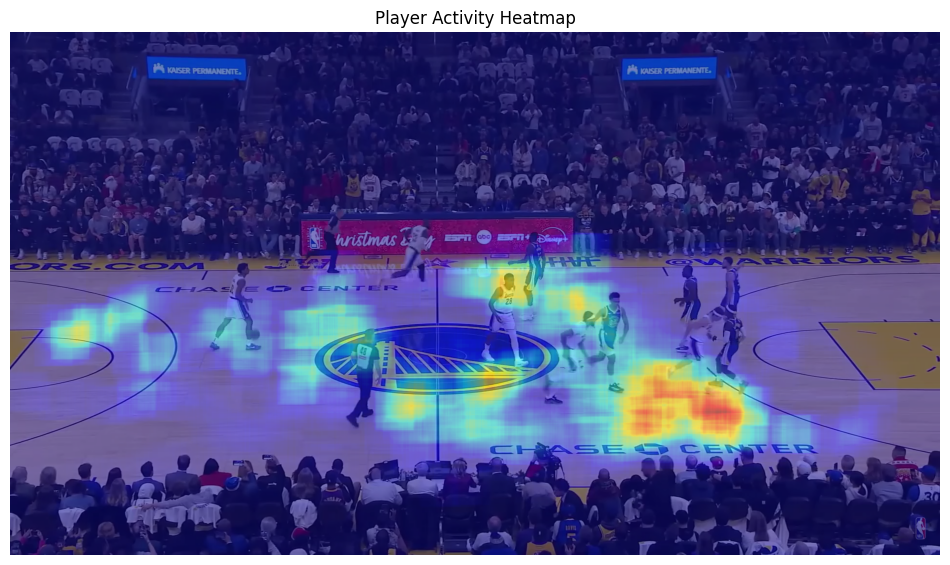

In [7]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
VIDEO_PATH = "Recording 2026-01-16 142635.mp4"
OUTPUT_IMAGE = "nba_heatmap_final.png"
OUTPUT_VIDEO = "nba_heatmap_timelapse.mp4"
MODEL_PATH = r"best (1).pt" 
MAX_FRAMES = 500  # 0 for full video

# --- HEATMAP SETTINGS ---
# Classes to include in heatmap (1=Team B, 2=Team A)
# We exclude Ref (3) and Ball (4) so they don't mess up the tactical map
TARGET_CLASSES = [1, 2] 

print(f"Loading Model: {MODEL_PATH}...")
model = YOLO(MODEL_PATH) 

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# We need a float matrix to accumulate heat (precision)
heat_matrix = np.zeros((h, w), dtype=np.float32)

# Video Writer for the timelapse
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (w, h))

print(f"Generating Heatmap from {VIDEO_PATH}...")

# Run Tracking
results = model.track(source=VIDEO_PATH, persist=True, stream=True, conf=0.3, verbose=False)

for i, res in enumerate(results):
    if MAX_FRAMES > 0 and i >= MAX_FRAMES: break
    
    # Copy original frame for the background
    frame = res.orig_img.copy()
    
    if res.boxes.id is None:
        out.write(frame)
        continue

    boxes = res.boxes.xyxy.cpu().numpy()
    cls = res.boxes.cls.cpu().numpy().astype(int)
    
    # --- ACCUMULATE HEAT ---
    for box, class_id in zip(boxes, cls):
        if class_id in TARGET_CLASSES:
            x1, y1, x2, y2 = map(int, box)
            
            # Center of the player's feet
            cx = (x1 + x2) // 2
            cy = y2
            
            # Add a "Gaussian Blob" (soft circle) to the heat matrix
            # Instead of adding 1 pixel, we add a soft circle of radius 30
            radius = 40
            sigma = 15
            
            # Define bounds to stay inside image
            y_min, y_max = max(0, cy-radius), min(h, cy+radius)
            x_min, x_max = max(0, cx-radius), min(w, cx+radius)
            
            # Add value (Simple optimization: just adding constant value for speed)
            # You can make this a gaussian distribution for smoother results
            heat_matrix[y_min:y_max, x_min:x_max] += 1.0

    # --- VISUALIZE LIVE (Optional: Create Timelapse) ---
    # Normalize heat matrix to 0-255
    heatmap_norm = cv2.normalize(heat_matrix, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Apply Color Map (JET: Blue=Cold, Red=Hot)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
    
    # Overlay on frame
    alpha = 0.5
    # Only colorize where there is heat (mask)
    mask = heatmap_norm > 5 # Hide the dark blue background
    
    overlay = frame.copy()
    overlay[mask] = cv2.addWeighted(heatmap_color, 0.6, frame, 0.4, 0)[mask]
    
    out.write(overlay)
    
    if i % 50 == 0: print(f"Processed {i} frames...")

cap.release()
out.release()

# --- SAVE FINAL STATIC IMAGE ---
# Create one high-quality final image on the FIRST frame
cap = cv2.VideoCapture(VIDEO_PATH)
ret, first_frame = cap.read()
cap.release()

if ret:
    heatmap_norm = cv2.normalize(heat_matrix, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)
    
    # Blend
    final_overlay = cv2.addWeighted(heatmap_color, 0.5, first_frame, 0.5, 0)
    
    cv2.imwrite(OUTPUT_IMAGE, final_overlay)
    print(f"✅ Final Heatmap Image saved: {OUTPUT_IMAGE}")
    print(f"✅ Heatmap Video saved: {OUTPUT_VIDEO}")
    
    # Show in notebook
    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(final_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Player Activity Heatmap")
    plt.show()

---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
